# Speech Understanding 
# Lecture 10: Fourier analysis of natural speech

### Mark Hasegawa-Johnson, KCGI

* A synthetic vowel can be analyzed by taking the Fourier transform of the whole numpy array
* Real speech changes over time
* In order to cope with the changes over time, we can use the short-time Fourier transform (STFT)
* The log magnitude STFT is called the spectrogram

Here are the contents:
1. <a href="#section1">Using ipywebrtc to record speech</a>
1. <a href="#section2">Using librosa to read speech audio files</a>
1. <a href="#section3">Calculating a spectrogram using `np.fft.fft`</a>
1. <a href="#section4">Calculating a spectrogram using librosa</a>
1. <a href="#homework">Homework</a>

<a id='section1'></a>

## 1.  Using <a href="https://ipywebrtc.readthedocs.io/en/latest/">ipywebrtc</a> to record speech

[ipywebrtc](https://ipywebrtc.readthedocs.io/en/latest/) is a general package for recording audio and video into your Jupyter notebook.

In order to use ipywebrtc, first you need to install it.  You can do that using the following shell command, or by issuing the same command without the "!" in a terminal window:

In [8]:
!pip install ipywebrtc

Recording audio using ipywebrtc is exactly the same as recording video, except that we create a `CameraStream` object with the constraints `'audio':True, 'video':False`.  With those constraints, the camera stream will record only audio, not video.

When you the circle button is black, you can press it to start recording.  When it is red, you can press it to stop recording.

In [10]:
import ipywebrtc
camera = ipywebrtc.CameraStream(constraints={'audio': True,'video':False})
recorder = ipywebrtc.AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

If we print the `recorder` object, we can see its contents:

In [12]:
print(recorder)

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': False}))


We can see that it is an `AudioRecorder` object, with the following member data:
* audio - an audio object, containing
   * value - the binary data of the recorded audio waveform
   * format='webm' - the audio coding format in which audio.value is stored
* stream - the `CameraStream` object from which the audio was recorded

There are several ways to convert the `audio.value` data into a numpy array, but one of the simplest and most general is to just save it as a binary `.webm` file, then read it in. 

In [14]:
with open('recording.webm','wb') as f:
    f.write(recorder.audio.value)
    
import os
print('recording.webm is a file containing',os.stat('recording.webm').st_size,'bytes')

recording.webm is a file containing 0 bytes


<a id='section2'></a>

## 2. Using [librosa](https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html) to read speech audio files

[librosa](https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html) is a very general package for synthesizing and analyzing audio files.  For now, let's use it to read in the `.webm` file you just created.  First, you need to install it.  In this line, the `-q` flag prevents pip from printing anything unless there is an error.  If nothing is printed, then you have no errors:

In [18]:
!pip -q install librosa

The [librosa.load](https://librosa.org/doc/latest/generated/librosa.load.html#librosa.load) function is able to read a wider variety of audio file formats than any other python package I know.

length of the audio is 30094 samples, and sampling rate is 16000


Text(0.5, 1.0, 'Recording sampled at 16000 samples/second')

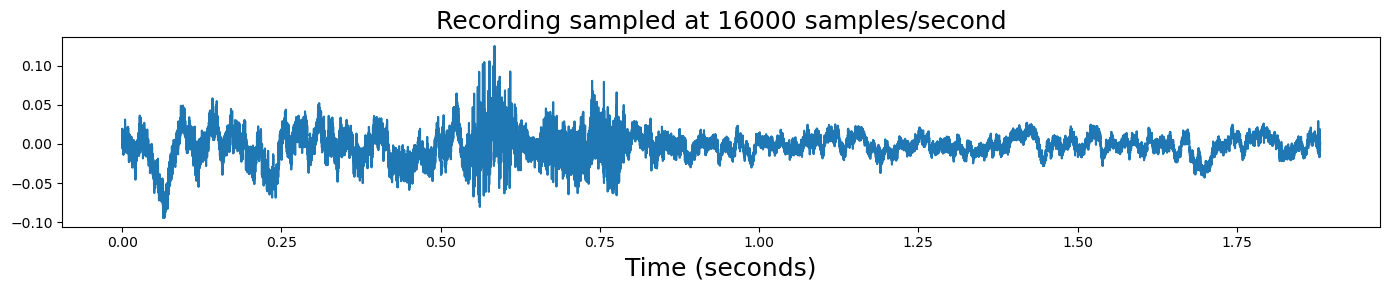

In [20]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

speech, Fs = librosa.load('recording.wav',sr=16000)
speech_time_axis = np.arange(len(speech))/Fs

print('length of the audio is',len(speech),'samples, and sampling rate is',Fs)

fig = plt.figure(figsize=(14,3),layout='tight')
subplot = fig.subplots(1,1)
subplot.plot(speech_time_axis,speech)
subplot.set_xlabel('Time (seconds)',fontsize=18)
subplot.set_title('Recording sampled at %d samples/second'%(Fs),fontsize=18)


<a id='section3'></a>

In [22]:
import IPython
IPython.display.Audio(data=speech,rate=Fs)

## 3. Calculating a spectrogram using np.fft.fft

* A Fourier transform finds out which tones are present in a sound
* ... but speech changes over time!

In order to solve this problem, we use the **short-time Fourier transform**, or STFT.  The STFT has two steps:

1. Divide `speech` into overlapping frames, resulting in a matrix
1. Take the Fourier transform of each frame to get the **STFT**
1. The **spectrogram** is the log magnitude of the STFT

### 3.1 Divide speech into overlapping frames

Typically, we use frames that are about 0.025 seconds long (25 milliseconds), with a step of 0.01 seconds (10 milliseconds).

There are an amazing number of different tricky ways to create overlapping frames in python; see [this page](https://stackoverflow.com/questions/2485669/consecutive-overlapping-subsets-of-array-numpy-python) for lots of methods.  The code below is intended to avoid tricky approaches.

In [26]:
frame_length = int(0.025*Fs)
step = int(0.01*Fs)
num_frames = int((len(speech)-frame_length)/step)
print('frame_length is',frame_length,'and step is',step,'and num_frames is',num_frames)

speech_frames = np.zeros((frame_length, num_frames))
for frame in range(num_frames):
    speech_frames[:,frame] = speech[frame*step:frame*step+frame_length]

frame_length is 400 and step is 160 and num_frames is 185


We can plot this as an image.  Most of the samples will be near zero, and only a few will be strongly negative or strongly positive:

Text(0.5, 1.0, 'Image of speech frames, 25ms frames with a 10ms step')

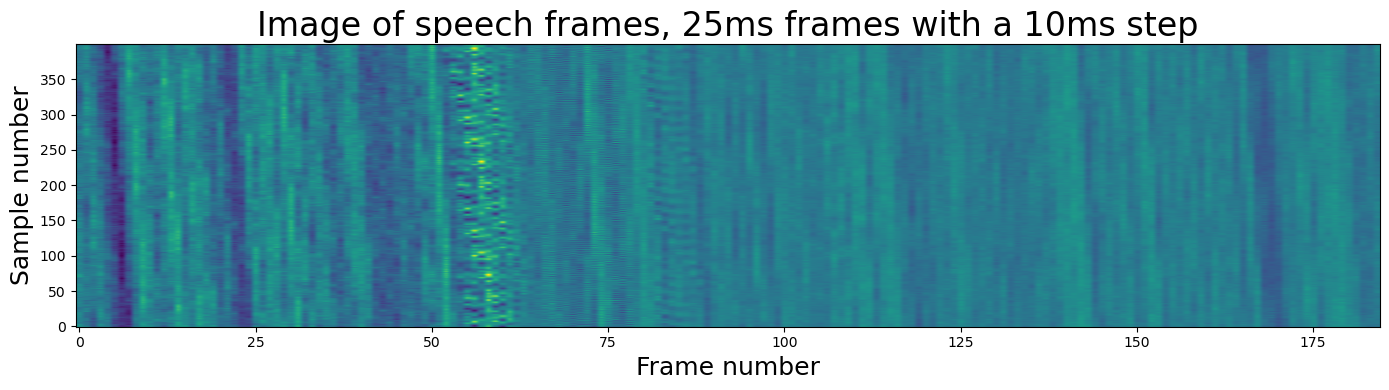

In [28]:
fig = plt.figure(figsize=(14,4),layout='tight')
subplot = fig.subplots(1,1)
subplot.imshow(speech_frames,aspect='auto',origin='lower')
subplot.set_xlabel('Frame number',fontsize=18)
subplot.set_ylabel('Sample number',fontsize=18)
subplot.set_title('Image of speech frames, 25ms frames with a 10ms step',fontsize=24)

### 3.2 Take the FFT of each frame to get the STFT

The STFT is computed by taking the FFT of each frame:

Text(0.5, 1.0, 'Image of speech frames, 25ms frames with a 10ms step')

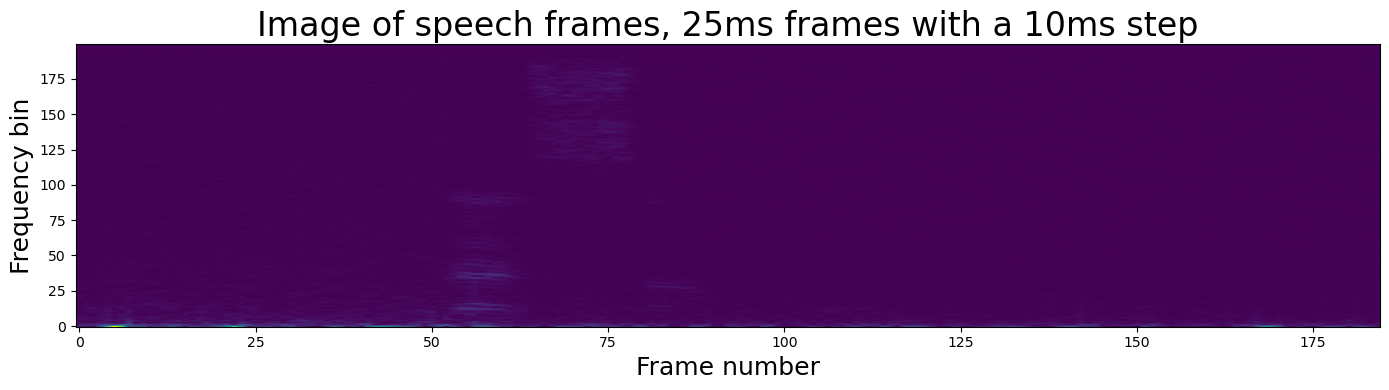

In [30]:
speech_stft = np.fft.fft(speech_frames, axis=0)

fig = plt.figure(figsize=(14,4),layout='tight')
subplot = fig.subplots(1,1)
subplot.imshow(np.abs(speech_stft[:frame_length//2]),aspect='auto',origin='lower')
subplot.set_xlabel('Frame number',fontsize=18)
subplot.set_ylabel('Frequency bin',fontsize=18)
subplot.set_title('Image of speech frames, 25ms frames with a 10ms step',fontsize=24)


### 3.3 The spectrogram is the log magnitude STFT

As you can see from the plot above, the STFT is close to zero in most frequency bins.  Low-amplitude information can be made more visible by taking the logarithm.

#### Standardization: Use decibels, `20*log10(abs(stft))`
If you use `np.log` to calculate the logarithm, then your spectrogram units are not obvious.  If you use `20*np.log10`, then you can say that your spectrogram expresses levels in units of decibels.  The <a href="https://en.wikipedia.org/wiki/Decibel">decibel</a> is an international standard way of expressing logarithms.  Since it's an international standard, it's nice to use it.

#### Normalization: Normalize maximum to 0dB, Clip minimum to -60dB
In order to avoid taking the logarithm of zero, it's a good idea to use `np.amax` and `np.maximum` so that the largest value is 0dB ($=20\log_{10}(1)$), and the smallest value is -60dB ($=20\log_{10}(0.001)$).

Text(0.5, 1.0, 'Image of speech frames, 25ms frames with a 10ms step')

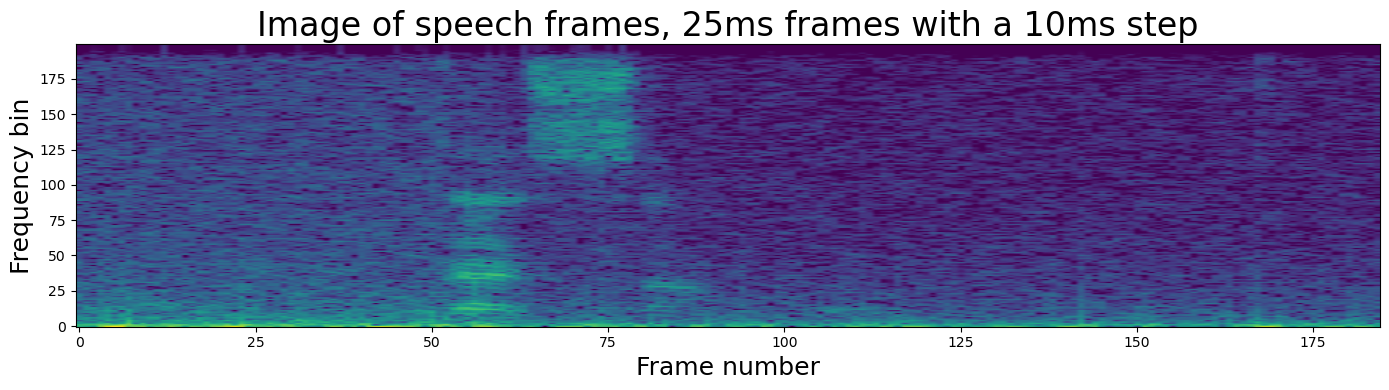

In [33]:
mstft = np.abs(speech_stft)
speech_spectrogram = 20*np.log10(np.maximum(0.001,mstft/np.amax(mstft)))
                            
fig = plt.figure(figsize=(14,4),layout='tight')
subplot = fig.subplots(1,1)
subplot.imshow(speech_spectrogram[:frame_length//2],aspect='auto',origin='lower')
subplot.set_xlabel('Frame number',fontsize=18)
subplot.set_ylabel('Frequency bin',fontsize=18)
subplot.set_title('Image of speech frames, 25ms frames with a 10ms step',fontsize=24)


<a id='section4'></a>

## 4. Calculating a spectrogram using librosa

librosa contains some useful functions:

* <a href="https://librosa.org/doc/main/generated/librosa.stft.html">librosa.stft</a> will chop a signal into frames, and find the STFT
* <a href="https://librosa.org/doc/main/generated/librosa.amplitude_to_db.html">librosa.amplitude_to_db</a> converts the magnitude to decibels
* <a href="https://librosa.org/doc/main/generated/librosa.display.specshow.html#librosa.display.specshow">librosa.display.specshow</a> has some extra settings that are useful for making useful images of spectrograms; for example, it can label the X-axis in seconds, and the Y-axis in Hertz.


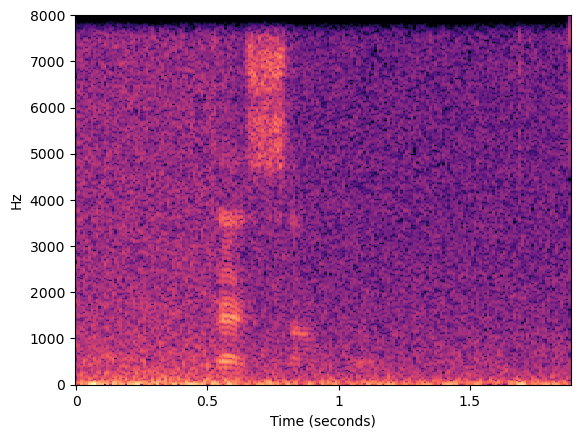

In [37]:
import librosa

step = int(0.01*Fs)
framelength = int(0.025*Fs)

librosa_stft = librosa.stft(speech,hop_length=step,win_length=framelength)
librosa_spectrogram = librosa.amplitude_to_db(np.abs(librosa_stft))
librosa.display.specshow(librosa_spectrogram,sr=Fs,hop_length=step,x_axis='s',y_axis='hz')

<a id="homework"></a>

## Homework 

Homework will be graded on Github.com.  Edit the file in this directory called `homework10.py`.  

### Homework 10.1: waveform_to_frames

In [42]:
import importlib, homework10
importlib.reload(homework10)
help(homework10.waveform_to_frames)

Help on function waveform_to_frames in module homework10:

waveform_to_frames(waveform, frame_length, step)
    Chop a waveform into overlapping frames.

    @params:
    waveform (np.ndarray(N)) - the waveform
    frame_length (scalar) - length of the frame, in samples
    step (scalar) - step size, in samples

    @returns:
    frames (np.ndarray((frame_length, num_frames))) - waveform chopped into frames

    num_frames should be at least int((len(speech)-frame_length)/step); it may be longer.
    For every n and t such that 0 <= t*step+n <= N-1, it should be the case that
       frames[n,t] = waveform[t*step+n]



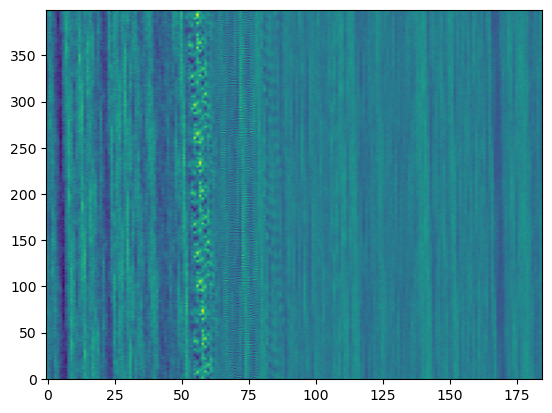

In [43]:
importlib.reload(homework10)
frames = homework10.waveform_to_frames(speech, frame_length, step)
plt.imshow(frames,origin='lower',aspect='auto')

### Homework 10.2: frames_to_stft

In [45]:
importlib.reload(homework10)
help(homework10.frames_to_stft)

Help on function frames_to_stft in module homework10:

frames_to_stft(frames)
    Take the FFT of every column of the frames matrix.

    @params:
    frames (np.ndarray((frame_length, num_frames))) - the speech samples (real-valued)

    @returns:
    stft (np.ndarray((frame_length,num_frames))) - the STFT (complex-valued)



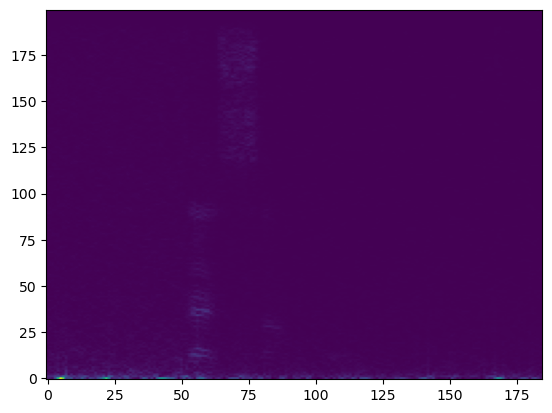

In [46]:
importlib.reload(homework10)
stft = homework10.frames_to_stft(frames)
plt.imshow(np.abs(stft[:frame_length//2]),origin='lower',aspect='auto')

### Homework 10.3: stft_to_spectrogram

In [48]:
importlib.reload(homework10)
help(homework10.stft_to_spectrogram)

Help on function stft_to_spectrogram in module homework10:

stft_to_spectrogram(stft)
    Calculate the level, in decibels, of each complex-valued sample of the STFT,
    normalized so the highest value is 0dB,
    and clipped so that the lowest value is -60dB.

    @params:
    stft (np.ndarray((frame_length,num_frames))) - STFT (complex-valued)

    @returns:
    spectrogram (np.ndarray((frame_length,num_frames)) - spectrogram (real-valued)

    The spectrogram should be expressed in decibels (20*log10(abs(stft)).
    np.amax(spectrogram) should be 0dB.
    np.amin(spectrogram) should be no smaller than -60dB.



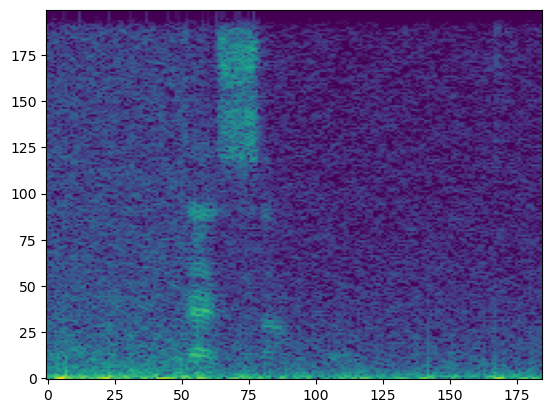

In [49]:
importlib.reload(homework10)
spectrogram = homework10.stft_to_spectrogram(stft)
plt.imshow(spectrogram[:frame_length//2],origin='lower',aspect='auto')

### Receiving your grade

In order to receive a grade for your homework, you need to:

1. Run the following code block on your machine.  The result may list some errors, and then in the very last line, it will show a score.  That score (between 0% and 100%) is the grade you have earned so far.  If you want to earn a higher grade, please continue editing `homework3.py`, and then run this code block again.
1. When you are happy with your score (e.g., when it reaches 100%), choose `File` $\Rightarrow$ `Save and Checkpoint`.  Then use `GitHub Desktop` to commit and push your changes.
1. Make sure that the 100% shows on your github repo on github.com.  If it doesn't, you will not receive credit.

In [51]:
import importlib, grade
importlib.reload(grade)

...
----------------------------------------------------------------------
Ran 3 tests in 0.017s

OK
...
----------------------------------------------------------------------
Ran 3 tests in 0.018s

OK


3 successes out of 3 tests run
Score: 100%
3 successes out of 3 tests run
Score: 100%


<module 'grade' from 'C:\\Users\\KIEV\\Documents\\Japan 2024\\KCGI\\2024 Autumn Second Semester\\01 Speech Understanding\\intro_speech_understanding\\2024_fall\\lec10\\grade.py'>